In [38]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [72]:
class Value:
    def __init__(self, data, _children=(), op='', label=''):
        self.data = data # track current value
        self.grad = 0.0 # track object gradient
        self._backward = lambda: None # backward function of object
        self._prev = set(_children) # children of current value in computational graph
        self.label = label
        self.op = op
        
    def __repr__(self):
        # override python's default object representation
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        # output of addition 
        out = Value(self.data + other.data , (self, other), '+')
        # gradient function for the addition operation
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
    
        return out

    def __radd__(self, other):
        return self + other

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        # output of multiplication
        out = Value(self.data * other.data, (self, other), '*')
        # gradient function for the multiplication operation
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __rtruediv__(self, other):
        return other * self**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        t = math.e ** x
        out = Value(t, (self, ), 'exp')

        def _backward():
            self.grad += t * out.grad

        return out
        
    
    def tanh(self):
        # hyperbolic tangent activation function
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        # gradient of hyperbolic tangent
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        # dfs-based topological sorting algorithm
        def build_topo(v):
            if v not in visited:
                visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
        build_topo(self)

        # traverse topological in reverse order moving from children to their parents and track accumulated gradients
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [73]:
from graphviz import Digraph 

def trace(root):
    # dfs for graph to get set of nodes and edges
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    # visualize computation graph
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
   
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n.op:
            dot.node(name= uid + n.op, label=n.op)
            dot.edge(uid + n.op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)) , str(id(n2)) + n2.op)
    
    return dot

In [74]:
#inputs    
x_1 = Value(2.0, label='x_1')    
x_2 = Value(0.0, label='x_2')

#weights
w_1 = Value(-3.0, label='w_1')
w_2 = Value(1.0, label='w_2')

#bias of neuron
b = Value(6.88137358, label='b')

xw1 = x_1 * w_1;  xw1.label = 'xw1'
xw2 = x_2 * w_2;  xw2.label = 'xw2'
xw = xw1 + xw2; xw.label = 'xw'
n = xw + b; n.label = 'n'
o = n.tanh(); o.label = 'output'


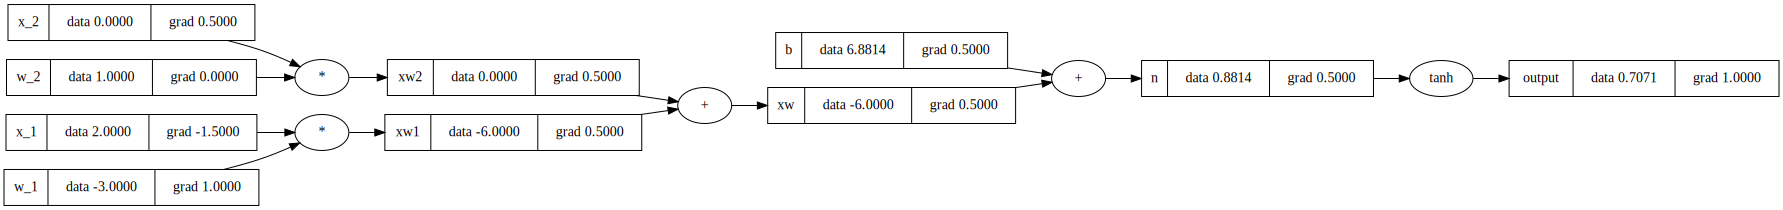

In [75]:
o.backward()
draw_dot(o)

In [76]:
import torch
x_1 = torch.Tensor([2.0]).double()      ; x_1.requires_grad = True
x_2 = torch.Tensor([0.0]).double()      ; x_2.requires_grad = True
w_1 = torch.Tensor([-3.0]).double()     ; w_1.requires_grad = True
w_2 = torch.Tensor([1.0]).double()      ; w_2.requires_grad = True
b = torch.Tensor([6.88137358]).double() ; b.requires_grad = True
n = x_1 * w_1 + x_2 * w_2 + b 
o = torch.tanh(n)

print('o', o.data.item())
o.backward()

print('x_2', x_2.grad.item())
print('w_2', w_2.grad.item())
print('x_1', x_1.grad.item())
print('w_2', w_1.grad.item())


o 0.7071066904050358
x_2 0.5000001283844369
w_2 0.0
x_1 -1.5000003851533106
w_2 1.0000002567688737


In [82]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum([wi * xi for wi, xi in zip(self.w, x)], self.b)
        out = act.tanh()
        return out
            
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__():
        outs = [n(x) for n in self.neurons]
        return outs
        
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__():
        for layer in self.layers:
            x = layer(x)
        return x